<a href="https://colab.research.google.com/github/andremanhas/Tech_Challenge/blob/main/precopetroleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Preços do S&P 500

Este notebook aborda a análise dos preços do S&P 500. Vamos realizar uma análise exploratória dos dados, seguida pelo treinamento de modelos de séries temporais e avaliação de seus desempenhos.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Métricas de avaliação dos modelos

In [ ]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## 1. Coleta de Dados

In [ ]:
# Coletando Dados do S&P 500
ticker = "SPY"
data = yf.download(ticker, start="2010-01-01", end="2024-07-18")
data = data[["Open", "Close"]]
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"])

# Exibindo os primeiros registros
print(data.head())

[*********************100%%**********************]  1 of 1 completed

        Date        Open       Close
0 2010-01-04  112.370003  113.330002
1 2010-01-05  113.260002  113.629997
2 2010-01-06  113.519997  113.709999
3 2010-01-07  113.500000  114.190002
4 2010-01-08  113.889999  114.570000


In [ ]:
print(data.tail())

           Date        Open       Close
3653 2024-07-11  561.440002  556.479980
3654 2024-07-12  557.630005  559.989990
3655 2024-07-15  562.030029  561.530029
3656 2024-07-16  562.869995  564.859985
3657 2024-07-17  558.799988  556.940002


## 2. Análise Exploratória dos Dados

### Visualização dos Dados

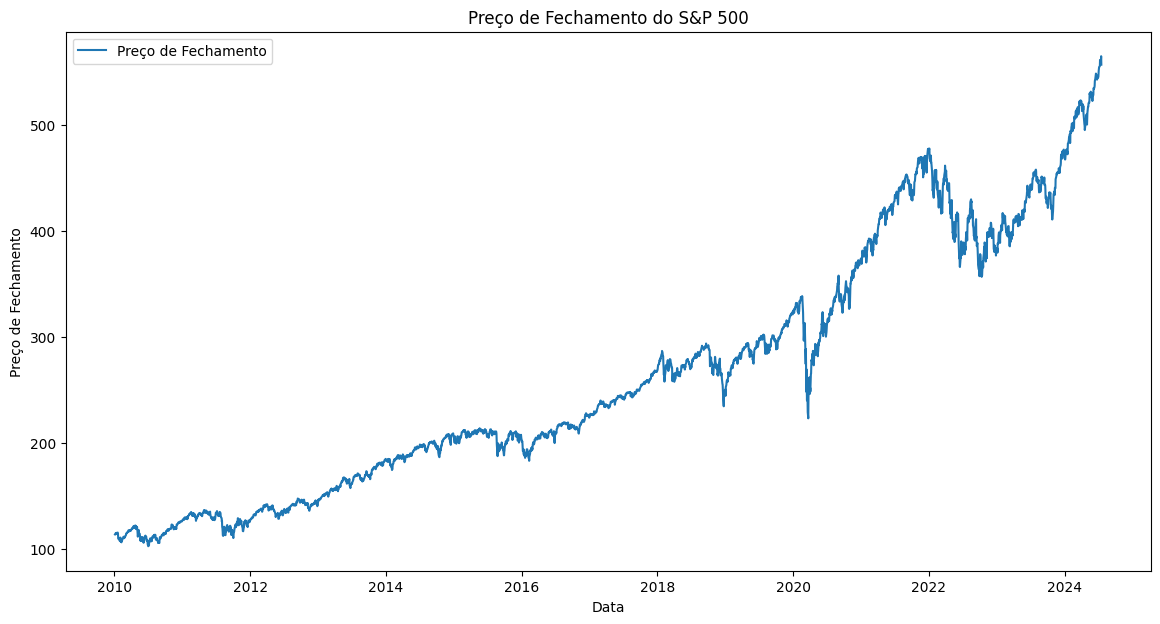

In [ ]:
# Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Preço de Fechamento")
plt.title("Preço de Fechamento do S&P 500")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

### Decomposição da Série Temporal

In [ ]:
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)

<Axes: >

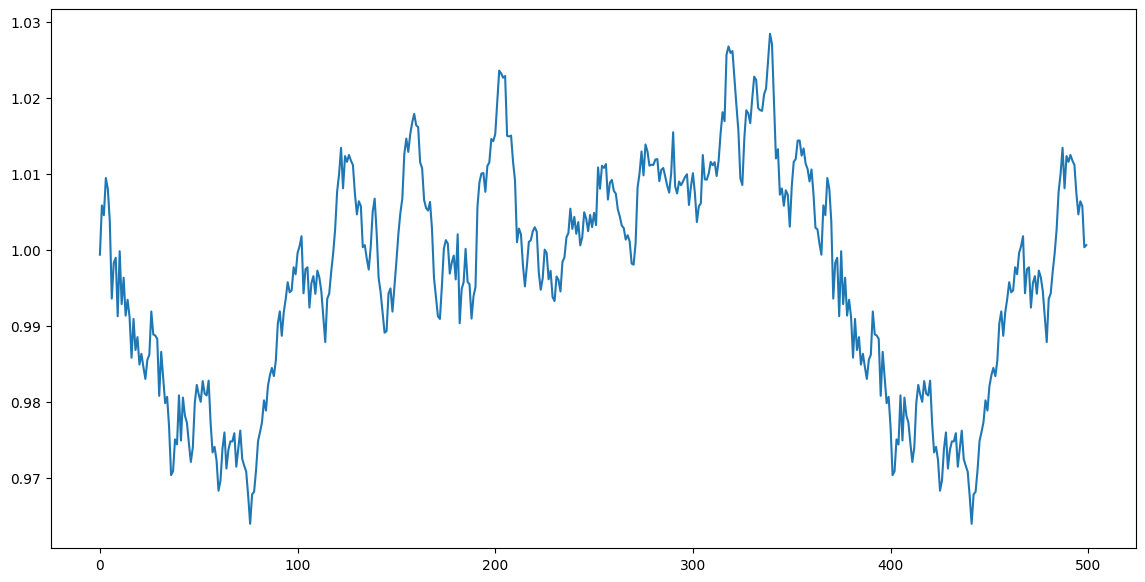

In [ ]:
result.seasonal.iloc[:500].plot(figsize=(14, 7))

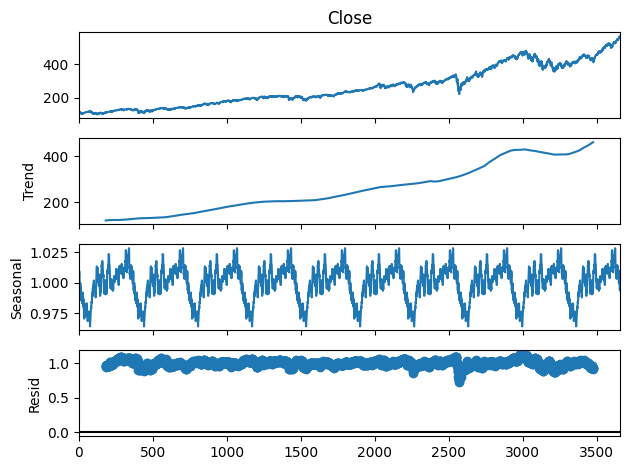

In [ ]:
# Decomposição da série temporal
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)
result.plot()
plt.show()

### Estatísticas Descritivas

In [ ]:
# Estatísticas descritivas
data["Close"].describe()

count    3658.000000
mean      262.979470
std       115.818783
min       102.199997
25%       168.619999
50%       236.770004
75%       357.769997
max       564.859985
Name: Close, dtype: float64

### Verificação de Dados Ausentes

In [ ]:
# Verificação de dados ausentes

missing_values = data.isnull().sum()
missing_values

Date     0
Open     0
Close    0
dtype: int64

## 3. Preparação dos Dados e Modelagem

### Dividindo os Dados em Treino e Teste

In [ ]:
# Dividindo em treino e teste

train_size = data.shape[0] - 7
train, test = data[:train_size], data[train_size:]


# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "Open"]
TARGET = "Close"

### Modelo XGBoost

In [ ]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 5.997637067522321
MSE: 42.13748532906175
MAPE: 1.0695305754129336


In [ ]:
# "backtesting"
# preds = []
# for i in range(7, 1, -1):
#     train_size = data.shape[0] - i
#     train, test = data[:train_size], data[train_size : train_size + 1]

#     train = create_features(train)
#     test = create_features(test)

#     # Modelo XGBoost
#     X_train, y_train = train[FEATURES], train[TARGET]
#     X_test, y_test = test[FEATURES], test[TARGET]

#     reg = xgb.XGBRegressor(objective="reg:squarederror")
#     reg.fit(X_train, y_train)

#     # Avaliação XGBoost
#     preds.append(reg.predict(X_test))

In [ ]:
# print_metrics(calculate_metrics(data["Close"][-7:-1], [p[0] for p in preds]))

MAE: 4.053873697916667
MSE: 23.00106689830621
MAPE: 0.7229408185165318


<Axes: xlabel='Date'>

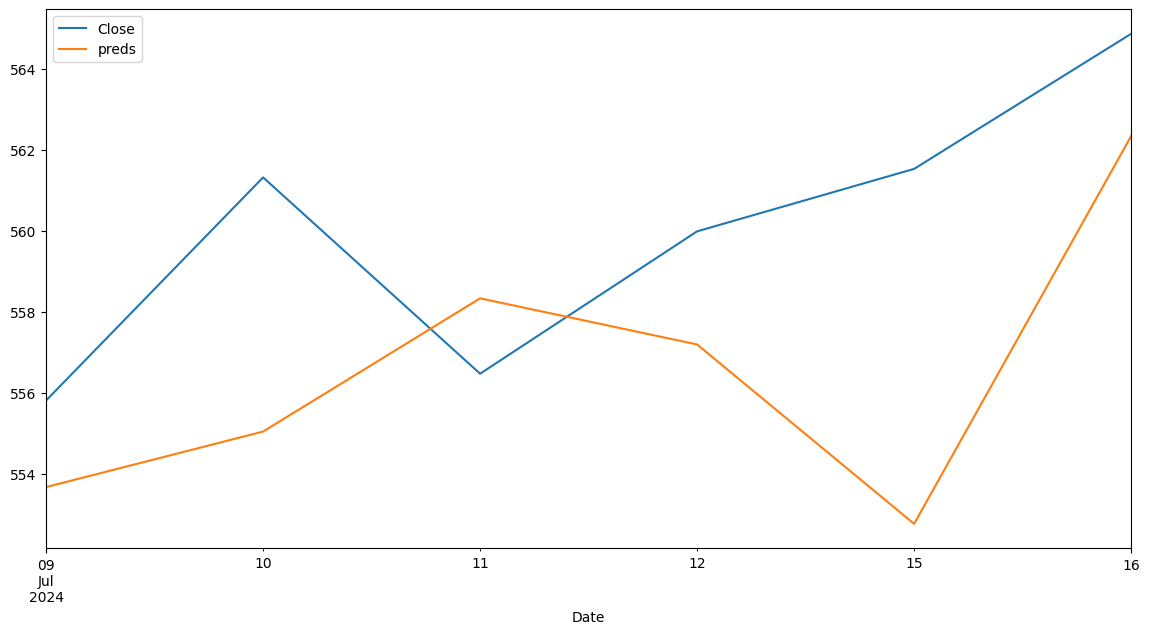

In [ ]:
# results = data[["Date", "Close"]].iloc[-7:-1]
# results["preds"] = [p[0] for p in preds]

# results.plot(x="Date", y=["Close", "preds"], figsize=(14, 7))

### Modelo Prophet

In [ ]:
# Modelo Prophet
train_prophet = train.rename(columns={"Date": "ds", "Close": "y"})
test_prophet = test.rename(columns={"Date": "ds", "Close": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("Open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Open"] = pd.concat([train["Open"], test["Open"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

20:30:10 - cmdstanpy - INFO - Chain [1] start processing
20:30:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 7.885767648926276
MSE: 129.86948095508927
MAPE: 0.5249069506617984


### Modelo SARIMAX

In [ ]:
# Modelo SARIMAX
exog_train = train[["Open"]]
exog_test = test[["Open"]]

model = sm.tsa.statespace.SARIMAX(
    train["Close"], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["Close"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54007D+00    |proj g|=  1.55264D-01


 This problem is unconstrained.



At iterate    5    f=  2.34985D+00    |proj g|=  5.61310D-02

At iterate   10    f=  2.28607D+00    |proj g|=  3.13267D-01

At iterate   15    f=  2.26846D+00    |proj g|=  1.09664D-01

At iterate   20    f=  2.26594D+00    |proj g|=  2.09182D-02

At iterate   25    f=  2.26583D+00    |proj g|=  1.84357D-03
  ys=-6.466E-07  -gs= 1.120E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     45      1     1     0   9.376D-04   2.266D+00
  F =   2.2658284764825973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMAX Metrics:
MAE: 2.3057927613098985
MSE: 7.8947874705917

# Comparando modelos

In [ ]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)
df

,MAE,MSE,MAPE
XGBoost,5.997637,42.137485,1.069531
Prophet,7.885768,129.869481,0.524907
SARIMAX,2.305793,7.894787,0.412058


## Conclusão

Neste notebook, realizamos uma análise detalhada dos preços do S&P 500. Após a análise exploratória, treinamos e avaliamos três modelos de séries temporais: XGBoost, Prophet e SARIMAX. As métricas de desempenho dos modelos foram calculadas para comparar sua eficácia na previsão dos preços de fechamento.